# SE-2200E Notebook 2: Data Preparation

Ningsong Shen

January 24, 2021

## Summary

In this notebook, the collected data is prepared for further processing in Python. A simple check is conducted to ensure the sensibility of the data. Note that this is the chart that can be found in the project proposal.

Get inspired: https://machinelearningmastery.com/start-here/

We have CSVs with actual stop times, scheduled stop times, and we want to combine them to run a regression to predict future times. 

In [1]:
import datetime as dt
import pandas as pd
import sklearn as sk

REALTIME_DATA_PATH = 'C:/Users/nings/OneDrive - The University of Western Ontario/Scholar\'s 2200E/result_data/result.csv'
SCHEDULE_DATA_PATH = 'C:/Users/nings/Documents/GitHub/se-2200e/raw_data/schedule/stop_times.txt'

## Data Preparation
Remove excess features, identify outliers, regularization, transformation

In [2]:
realtime_df = pd.read_csv(REALTIME_DATA_PATH, sep=',', error_bad_lines=False, index_col=False)
realtime_df = realtime_df.drop(columns=['start_time', 'stop_id', 'vehicle_label', 'timestamp'])
realtime_df = realtime_df.rename(columns={'departure_time': 'realtime_departure_time'})

schedule_df = pd.read_csv(SCHEDULE_DATA_PATH, sep=',', error_bad_lines=False, index_col=False)
schedule_df = schedule_df.drop(columns=['arrival_time', 'drop_off_type', 'pickup_type', 'stop_headsign', 'stop_id', 'timepoint'])
schedule_df = schedule_df.rename(columns={'departure_time': 'scheduled_departure_time'})

combined_df = realtime_df.merge(schedule_df, how='inner', on=['trip_id', 'stop_sequence'])
combined_df.head()



,trip_id,start_date,route_id,stop_sequence,realtime_departure_time,vehicle_id,scheduled_departure_time
0,1346803,20201104,24,41,1604508849,3140,11:53:34
1,1346803,20201105,24,41,1604595120,3177,11:53:34
2,1346803,20201106,24,41,1604681520,3143,11:53:34
3,1346803,20201109,24,41,1604940720,3144,11:53:34
4,1346803,20201110,24,41,1605027120,3178,11:53:34


In [29]:
# Categorical
combined_df['trip_id'] = pd.Categorical(combined_df['trip_id'])

# Categorical
combined_df['route_id'] = pd.Categorical(combined_df['route_id'])

# Numeric
combined_df['stop_sequence'] = pd.to_numeric(combined_df['stop_sequence'], errors='coerce').fillna(0).astype(int)

# Convert UTC to EST
try:
    combined_df['realtime_departure_time'] = pd.to_datetime(combined_df['realtime_departure_time'], unit='s', errors='coerce').dt.tz_localize('utc').dt.tz_convert('America/Toronto').dt.time
except TypeError:
    pass

# Categorical
combined_df['vehicle_id'] = pd.Categorical(combined_df['vehicle_id'])

# Time
combined_df['scheduled_departure_time'] = pd.to_datetime(combined_df['scheduled_departure_time'], format='%H:%M:%S', errors='coerce').dt.time

combined_df.info()
combined_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128386 entries, 0 to 3128385
Data columns (total 7 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   trip_id                   category
 1   start_date                object  
 2   route_id                  category
 3   stop_sequence             int32   
 4   realtime_departure_time   object  
 5   vehicle_id                category
 6   scheduled_departure_time  object  
dtypes: category(3), int32(1), object(3)
memory usage: 122.5+ MB


,trip_id,start_date,route_id,stop_sequence,realtime_departure_time,vehicle_id,scheduled_departure_time
2207272,1346227,20201116,16,32,09:57:55,3178.0,09:58:40
981142,1330741,20201113,04,53,17:53:40,3518.0,17:58:17
144844,1347335,20201123,02,21,12:47:49,3174.0,12:47:49
1216295,1339271,20201110,27,34,19:41:00,3560.0,19:40:00
427272,1343657,20201112,93,14,14:33:53,3136.0,14:31:53
336517,1347394,20201111,2,49,14:10:30,3150.0,14:11:09
141032,1338050,20201110,20,33,12:57:45,3366.0,12:52:39
2088867,1339294,20201111,27,7,09:12:00,3033.0,09:11:00
2698738,1346301,20201107,16,40,15:18:28,3361.0,15:14:28
675441,1347056,20201106,35,7,16:07:38,3521.0,16:03:53


## Checking the Data
I see if the numbers make sense.

In [86]:
diff = pd.to_datetime(combined_df['realtime_departure_time'].astype(str)).dt.to_pydatetime() - pd.to_datetime(combined_df['scheduled_departure_time'].astype(str)).dt.to_pydatetime()

(array([  5322.,   6568.,  11560.,  33188.,  87748., 251827., 498305.,
        700027., 444394., 378717., 208939., 139860.,  97213.,  52639.,
         35997.]),
 array([-500.        , -433.33333333, -366.66666667, -300.        ,
        -233.33333333, -166.66666667, -100.        ,  -33.33333333,
          33.33333333,  100.        ,  166.66666667,  233.33333333,
         300.        ,  366.66666667,  433.33333333,  500.        ]),
 <a list of 15 Patch objects>)

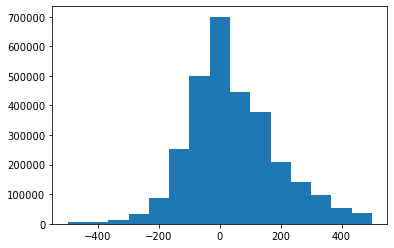

In [91]:
import matplotlib.pyplot as plt 
import numpy as np 

helper = np.vectorize(lambda x: x.total_seconds())
duration = helper(diff)

plt.hist(duration, range=[-500, 500], bins=15)

In [4]:
combined_df.to_csv('../clean_data/prepared_data.csv', index=False)

The residuals are normally distributed, which clearly show the variance that is involved when predicting bus times.